In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F

# For our model
import torchvision.models as models
from torchvision import datasets, transforms

# For utilities
import os, shutil, time

from PIL import Image

In [2]:
# NET CLASS
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(pretrained=True) #num_classes=365,
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):
    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [3]:
def pass2model(img,model):
    gray_img = np.asarray(img)[:,:,0]
    
    trsfm = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])

    img_t = trsfm(img)
    batch_t = torch.unsqueeze(img_t, 0)
    fin_img = model(trsfm(img)[None, ...])[0,:,:,:]
    
    p = transforms.Compose([transforms.Scale((np.shape(gray_img)[0]-0,np.shape(gray_img)[1]-0))])
    
    l = gray_img/2.9
    a = (p(fin_img).detach().numpy()[0].astype(np.float64) * 255 - 128 )
    b = (p(fin_img).detach().numpy()[1].astype(np.float64) * 255 - 128 )
    
    final = lab2rgb(np.dstack((l,a,b)).astype(np.float64))
    
    return(final)
    

# BERD

In [4]:
# Load model
berd_model = ColorizationNet()
pretrained = torch.load('./berd_model.pth',map_location=torch.device('cpu') )
berd_model.load_state_dict(pretrained)

berd_model.eval()

ColorizationNet(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [5]:
img = Image.open("./berd4.jpg")

pass2model(img,berd_model)

/home/saverio/anaconda3/envs/vision/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/saverio/anaconda3/envs/vision/lib/python3.8/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/home/saverio/anaconda3/envs/vision/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


array([[[0.        , 0.86072116, 0.93789209],
        [0.        , 0.86072116, 0.93789209],
        [0.6434866 , 0.79400173, 0.90178937],
        ...,
        [0.64839468, 0.79971975, 0.84165167],
        [0.37917082, 0.80655358, 1.        ],
        [0.37917082, 0.80655358, 1.        ]],

       [[0.        , 0.85973109, 0.93492304],
        [0.        , 0.85973109, 0.93492304],
        [0.64608361, 0.79372734, 0.89914488],
        ...,
        [0.65037468, 0.79936175, 0.84080585],
        [0.38876973, 0.80618892, 1.        ],
        [0.38876973, 0.80618892, 1.        ]],

       [[0.74316381, 0.78606568, 0.74111274],
        [0.74316381, 0.78606568, 0.74111274],
        [0.782068  , 0.77631677, 0.72536994],
        ...,
        [0.76738367, 0.77484083, 0.78523501],
        [0.71725694, 0.78537262, 0.81812935],
        [0.71725694, 0.78537262, 0.81812935]],

       ...,

       [[0.81167288, 0.76940052, 0.70063352],
        [0.81167288, 0.76940052, 0.70063352],
        [0.84499475, 0

In [6]:
# TESTING BERD_MODEL ON HUMANS
img = Image.open("./human2.jpg")

pass2model(img,berd_model)

/home/saverio/anaconda3/envs/vision/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


array([[[0.        , 0.39519697, 0.43196066],
        [0.        , 0.39519697, 0.43196066],
        [0.26659704, 0.34433368, 0.35818807],
        ...,
        [0.25371261, 0.37337461, 0.38970426],
        [0.        , 0.37971938, 0.64191486],
        [0.        , 0.37971938, 0.64191486]],

       [[0.        , 0.39519697, 0.43196066],
        [0.        , 0.39519697, 0.43196066],
        [0.26659704, 0.34433368, 0.35818807],
        ...,
        [0.25371261, 0.37337461, 0.38970426],
        [0.        , 0.37971938, 0.64191486],
        [0.        , 0.37971938, 0.64191486]],

       [[0.32453051, 0.33960122, 0.2464597 ],
        [0.32453051, 0.33960122, 0.2464597 ],
        [0.35170797, 0.33423478, 0.20274596],
        ...,
        [0.35963104, 0.35249211, 0.3416702 ],
        [0.32746621, 0.35960481, 0.36225889],
        [0.32746621, 0.35960481, 0.36225889]],

       ...,

       [[0.62983901, 0.57415901, 0.42033982],
        [0.62618629, 0.57062998, 0.41696703],
        [0.63931946, 0

# HOOMAN

In [7]:
# Load model
human_model = ColorizationNet()
pretrained = torch.load('./hoom_model.pth',map_location=torch.device('cpu') )
human_model.load_state_dict(pretrained)

human_model.eval()

ColorizationNet(
  (midlevel_resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

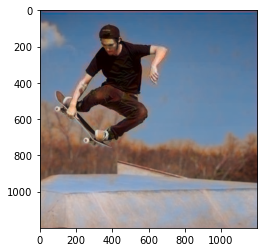

In [29]:
# TESTING HUMAN_MODEL ON HUMANS
img = Image.open("./human2.jpg")

plt.imshow(pass2model(img,human_model))

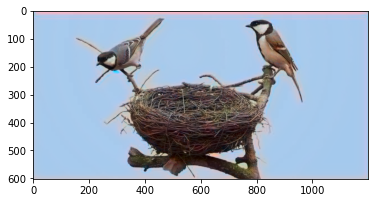

In [30]:
# TESTING HUMAN MODEL ON BIRDS
img = Image.open("./berd4.jpg")

plt.imshow(pass2model(img,human_model))

In [10]:
# PHOTOS OF BOTH

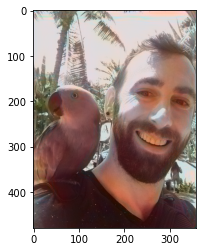

In [31]:
# TESTING HUMAN MODEL ON BOTH
img = Image.open("./both.jpg")

plt.imshow(pass2model(img,human_model))

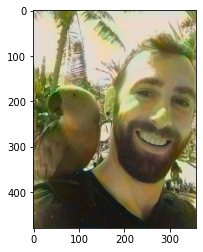

In [32]:
# TESTING HUMAN MODEL ON BOTH
img = Image.open("./both.jpg")

plt.imshow(pass2model(img,berd_model))

# MERGING

In [14]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow.compat.v1 as tf

In [15]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[2])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [16]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


2021-07-03 13:58:34.172083: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-03 13:58:34.172452: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-03 13:58:34.172977: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
import cv2

def getlabels(img):
    resized_img, seg_map = MODEL.run(img)
    labels = label_to_color_image(seg_map).astype(np.uint8)[:,:,0]
    
    labels = cv2.resize(labels, dsize=(np.shape(img)[1],np.shape(img)[0]), interpolation=cv2.INTER_NEAREST)
    
    return labels

In [51]:
img = Image.open("./both6.jpg")

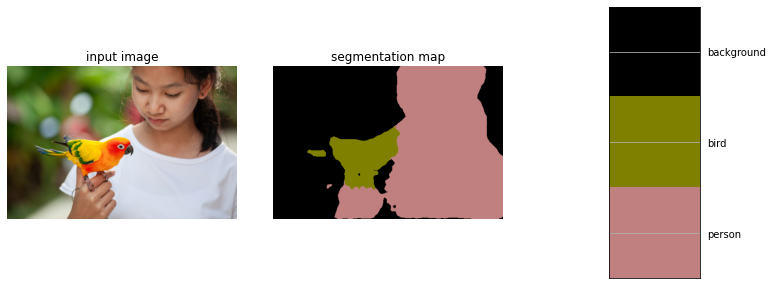

In [52]:
resized_img, seg_map = MODEL.run(img)
vis_segmentation(img, seg_map)

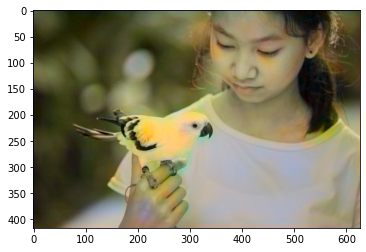

In [53]:
berd_img = pass2model(img,berd_model)
plt.imshow(berd_img)

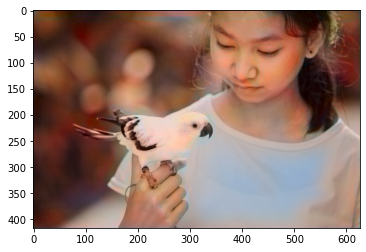

In [54]:
hoom_img = pass2model(img,human_model)
plt.imshow(hoom_img)

(417, 626)

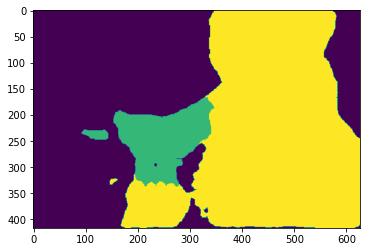

In [55]:
prob = getlabels(img)
plt.imshow(prob)
np.shape(prob)

In [56]:
fin_img = np.zeros(np.shape(img))

mask = prob == 128
W = np.shape(img)[0]
H = np.shape(img)[1]

print(W,H)

for w in range(W):
    for h in range(H):
        if prob[w,h] == 192:
            fin_img[w,h,:] = hoom_img[w,h,:]
        else :
            fin_img[w,h,:] = berd_img[w,h,:]    

417 626


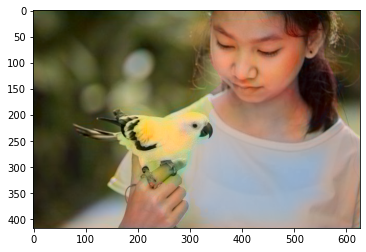

In [57]:
plt.imshow(fin_img)

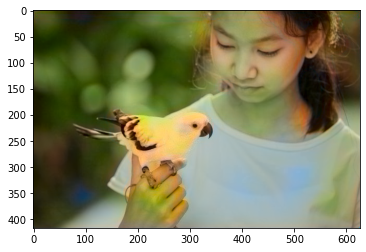

In [58]:
# Load model
both_model = ColorizationNet()
pretrained = torch.load('./both_model.pth',map_location=torch.device('cpu') )
both_model.load_state_dict(pretrained)

both_model.eval()

both_img = pass2model(img,both_model)
plt.imshow(both_img)